# Movie recommender

## Introduction

Movie recommendation is an exciting topic closely related to our daily lives.
It saves our precious time and energy to choose from millions of movies.
But no one could ever go through all millions of movies so as to make a good recommendation.
So this is the time when data science techniques such as **K Nearest Neighbor (KNN)** and **K-means** can help.
Here we will first use KNN model and then improve it with K-means clustering. Fun!

## Idea map

In this project we walk through the full processing of building our movie recommender.

This basic idea is to recommend movies based on the ranking of user's rating. The work mainly focuses on the following aspects:

1. Estimate user's movie rating by the average of K nearest neighbors and recommend by ratings' ranking.
2. Cluster movies to 3 groups by K-means and interpret each cluster by the top10 rated movies. 
3. Improve KNN by recommending movies in the same cluster.

## 1. Load data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data/movieReplicationSet.csv")

In [3]:
# There are 1097 users and 400 movies in our rating matrix.
data.shape

(1097, 400)

In [4]:
data.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,X-Men 2 (2003),The Usual Suspects (1995),The Mask (1994),Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,0.5,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,NaN,3.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.5,NaN,3.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN


## 2. Exploratory data analysis

In [5]:
# All rating values are numerical except for NaN
(data.dtypes != np.float64).sum()

0

In [6]:
# For each movie, there is at least one user who haven't watched it.
# So it is meaningful to recommend new movies for everyone.
(data.isna().sum() == 0).sum()

0

In [7]:
# For each movie, there is at least one user who have watched it.
# So it is possible that we get an estimate of users' rating for each movie.
data.isna().all().sum()

0

In [8]:
# Two users who have watched all 400 movies. 
# Their rating maybe important in recommending movies.
(data.isna().sum(axis = 1) == 0).sum()

2

In [9]:
# One user haven't watch any of the movies.
# So we know nothing about this user and can only drop this row.
data.isna().all(axis=1).sum()

1

In [10]:
# Drop the all NaN row
data.isna()[data.isna().all(axis=1)].index

Int64Index([896], dtype='int64')

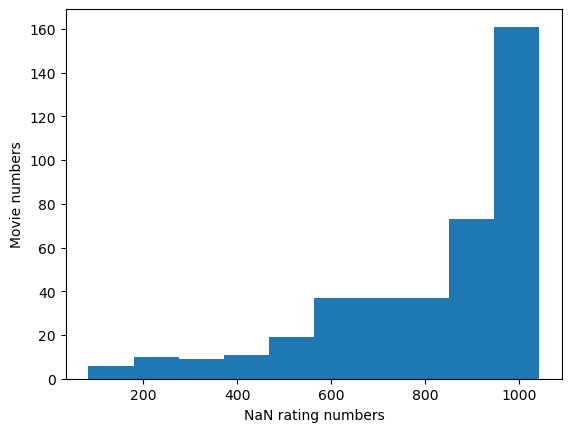

In [11]:
# Plot the distribution of NaN values' number for each movie
# The plot shows that: 
# Over 900 users have not watched half of movies. 
# So for these users a recommendation system is very necessary.
plt.hist(data.isnull().sum())
plt.xlabel('NaN rating numbers')
plt.ylabel('Movie numbers')
plt.show()

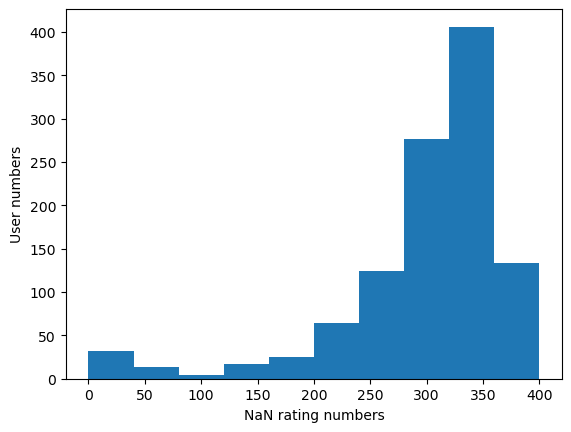

In [12]:
# Plot the distribution of NaN values' number for each user
# The plot shows that:
# 1. Most users have not watched half of the movies, which is consistent with our analysis above.
# 2. There are around 100 users who have watch most part of 400 movies. They can be good candidates for movie recommending.
plt.hist(data.isnull().sum(axis=1))
plt.xlabel('NaN rating numbers')
plt.ylabel('User numbers')
plt.show()

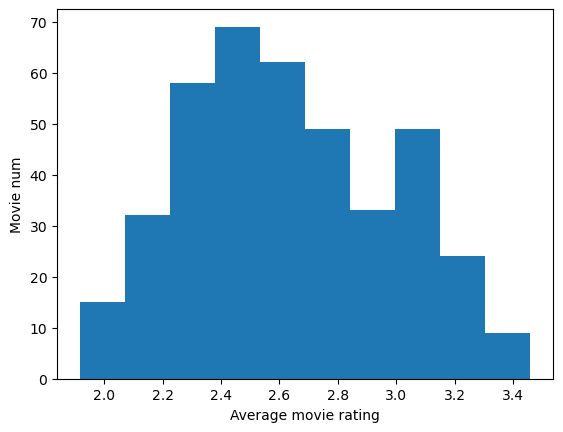

In [13]:
# Calculate average rating for each movie
# Plot histogram to see the distribution of average movie rating.
# By the plot below, we conclude that：
# 1. The distribution show a tendency of left-skewness. 
# 2. Extremely highly rated movies and lowly rated movies are rare. And most movies have moderate average rating. 
# 3. Some movie showing distinct higher average rating. This movies are probably good candidates for our further movie recommendation.
plt.hist(data.mean())
plt.xlabel('Average movie rating')
plt.ylabel('Movie num')
plt.show()

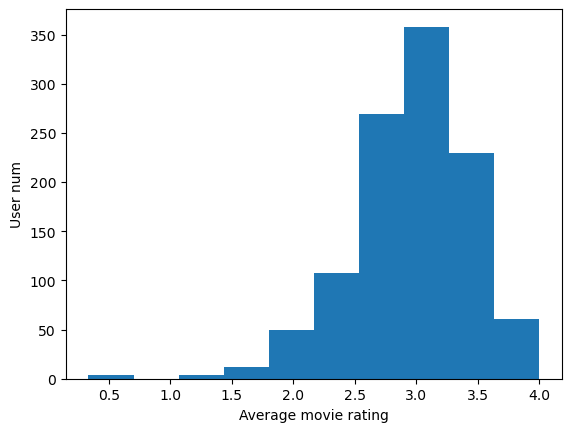

In [14]:
# Calculate average rating for each user
# Plot histogram to see the distribution of average users' rating.
# By the plot below, we conclude that：
# 1. Most users give average rating around 3, with some extremely low rating. 
# 2. This shows a potential pitfall for our Euclidean distance based model, because these users who gives extremely low rating may have tastes quite distinct with others.
plt.hist(data.mean(axis=1))
plt.xlabel('Average movie rating')
plt.ylabel('User num')
plt.show()

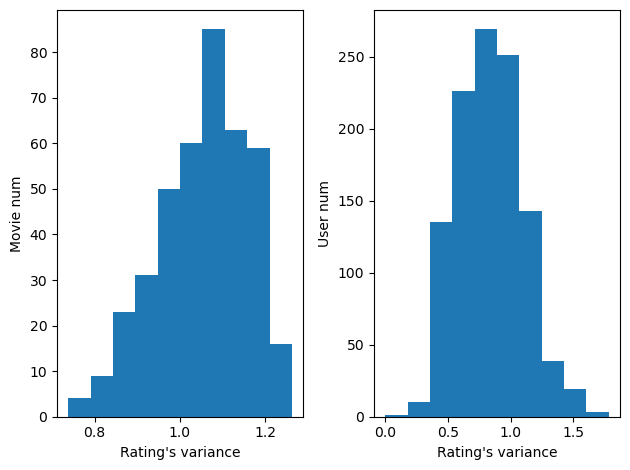

In [15]:
# Calculate ratings' standard deviation for each movie and histogram
# Plot histogram to see the distribution of ratings' variance.
# We can conclude from the plots below that the standard deviation is normally distributed.
fig, axs = plt.subplots(1, 2)
axs[0].hist(data.std())
axs[1].hist(data.std(axis=1))
axs[0].set_xlabel("Rating's variance")
axs[1].set_xlabel("Rating's variance")
axs[0].set_ylabel("Movie num")
axs[1].set_ylabel("User num")
fig.tight_layout()

## 3. KNN movie recommendation

### _A user-user approach_

KNN model follows this intuition of _"Similar minds think alike"_ and asks for the opinion of $K$ like-minded 'friends'.
With a similar taste, it is reasonable to assume that I would have a similar rating like my 'friends' though I haven't seen the movie yet.
In this way, we successfully estimate the rating of movies by the average rating of like-minded people. 

In [16]:
data_movie = data # make a data copy

In [17]:
# Employ KNN to estimate 
data_complete = KNNImputer(n_neighbors=10).fit_transform(data_movie)
data_complete = pd.DataFrame(data_complete, columns=data_movie.columns)

In [18]:
data_complete.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,X-Men 2 (2003),The Usual Suspects (1995),The Mask (1994),Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989)
0,2.80,2.05,4.00,3.05,3.0,2.65,2.70,3.55,3.10,3.35,...,2.95,3.60,3.15,4.00,0.50,2.60,2.65,2.95,2.60,2.70
1,2.05,2.30,1.50,2.70,2.5,2.85,2.30,2.85,2.50,3.05,...,2.45,3.45,3.00,2.35,4.00,2.95,2.15,2.75,2.80,3.05
2,3.10,2.60,3.25,2.50,3.2,2.85,2.65,3.35,2.80,3.05,...,3.15,3.55,3.05,2.65,3.50,3.25,2.80,2.90,2.85,3.30
3,2.50,2.35,2.00,3.10,3.0,2.80,1.90,3.65,3.25,4.00,...,2.20,3.00,1.85,2.95,2.50,2.60,1.60,2.30,2.70,2.05
4,2.65,2.40,3.50,2.30,0.5,2.15,0.50,1.00,2.75,0.00,...,2.50,3.10,3.00,2.05,2.65,2.50,1.80,1.50,2.50,2.20


In [19]:
# Recommend movie based on sorted rating
data_recommend = data_complete.mask(~data_movie.isna().values, -1) # Set already watched movies' rating to -1 so will not be recommended again
movie_list = pd.DataFrame(data_recommend.values.argsort(axis=1)[:,-5:]).applymap(lambda idx: data_recommend.columns[idx])

In [20]:
# Top 5 movies for each user
movie_list.head() 

,0,1,2,3,4
0,The Shawshank Redemption (1994),Schindler's List (1993),Rocky (1976),Memento (2000),Good Will Hunting (1997)
1,Life is Beautiful (1997),The Truman Show (1998),Dead Poets Society (1989),Se7en (1995),The Proposal (2009)
2,Good Will Hunting (1997),Kill Bill: Vol. 2 (2004),Kill Bill: Vol. 1 (2003),The Princess Bride (1987),Toy Story (1995)
3,Oldboy (2003),Fargo (1996),Goodfellas (1990),The Godfather (1972),Apocalypse Now (1979)
4,Schindler's List (1993),Spirited Away (2001),Good Will Hunting (1997),Life is Beautiful (1997),The Intouchables (2011)


## 4. Improve KNN movie recommendation with K-means

Except for overall recommendation, we have a lot of other real-world scenarios!
When I just finished a great movie, chances are that I would want more movies of the same kind.
Well, clustering model can help us do that!

Here we will deploy the basic clustering model **K-means** to recommend movies in the same **genre**.

### _An item-item approach_
    
The idea of K-means is quite similar to KNN with a little bit difference. 
In the KNN part we want the average rating from K like-minded friends.
But here we want more than that. We not only want to find similar movies, 
but also want to further group them up and give each groups **meaningful interpretation**!

In short by Silhouette score, our clustering result shows that there are **three** possible movie clusters. 
We further take mean average and take a look at the top 10 movies in each group.

But first to deal with the **curse of dimensionality** problem that would greatly impact the performance of K-means model, we employ PCA to reduce feature dimensions to 3. It is also more covenient for us to do data visualization.

### PCA dimension reduction

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [22]:
# Normalize data first because K-means would use the Euclidean norm as measure, which is sensitive to data scale.
X = data_complete.T
X_normalized = normalize(X, norm='l2')

In [23]:
# PCA dimension reduction
pca = PCA(n_components=3)
pca.fit(X_normalized)
pca_samples = pca.transform(X_normalized)
df_pca = pd.DataFrame(pca_samples)

In [24]:
df_pca.shape

(400, 3)

In [25]:
df_pca.head()

,0,1,2
0,-0.036619,0.006574,0.022693
1,-0.046018,0.023205,0.049823
2,-0.035363,-0.002059,0.028986
3,-0.058211,0.057794,-0.012169
4,-0.002619,0.008675,-0.002247


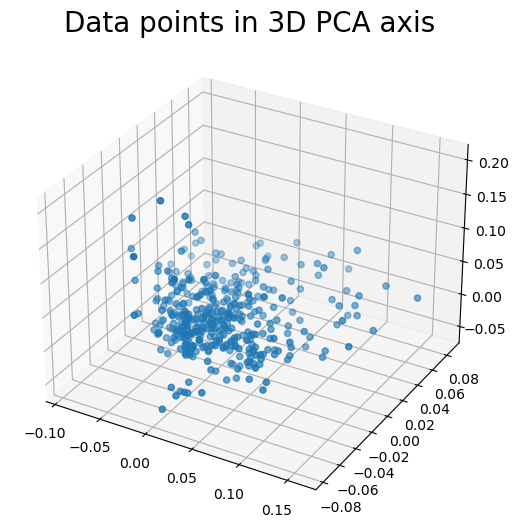

In [26]:
from mpl_toolkits.mplot3d import Axes3D
# plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_pca[0], df_pca[2], df_pca[1])
plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

## K-means clustering

### Choose K by silhouette score

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_pca)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(df_pca, kmeans.labels_))

### Visualization

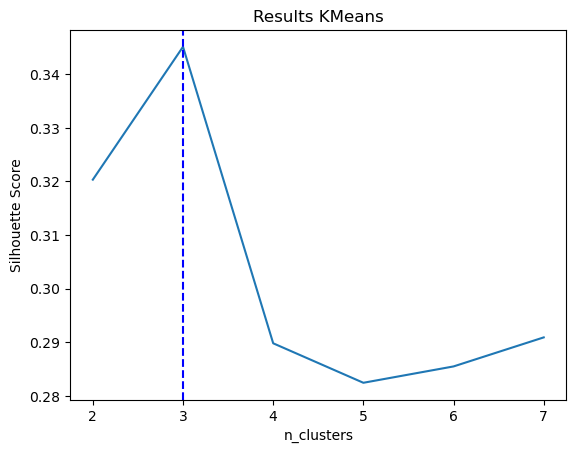

In [28]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=3, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

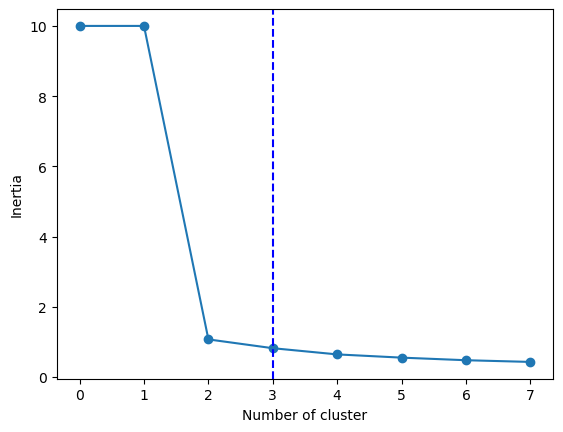

In [29]:
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=3, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

By the silhouette score we choose K=3 that give a peak in the plot, which also corresponds to a good in-group distance sum.  

In [30]:
# Implement with k=3
clusterer = KMeans(n_clusters=3,random_state=30).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)

print(centers)

[[ 0.04654975 -0.0037224   0.00202083]
 [-0.02618303 -0.00827173  0.00240377]
 [-0.01541922  0.09068325 -0.03122204]]


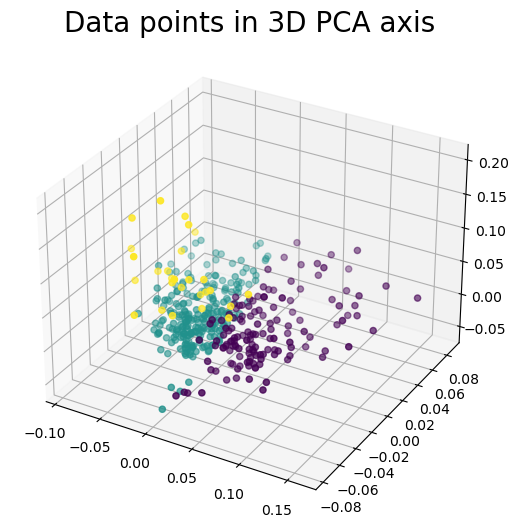

In [31]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_pca[0], df_pca[2], df_pca[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

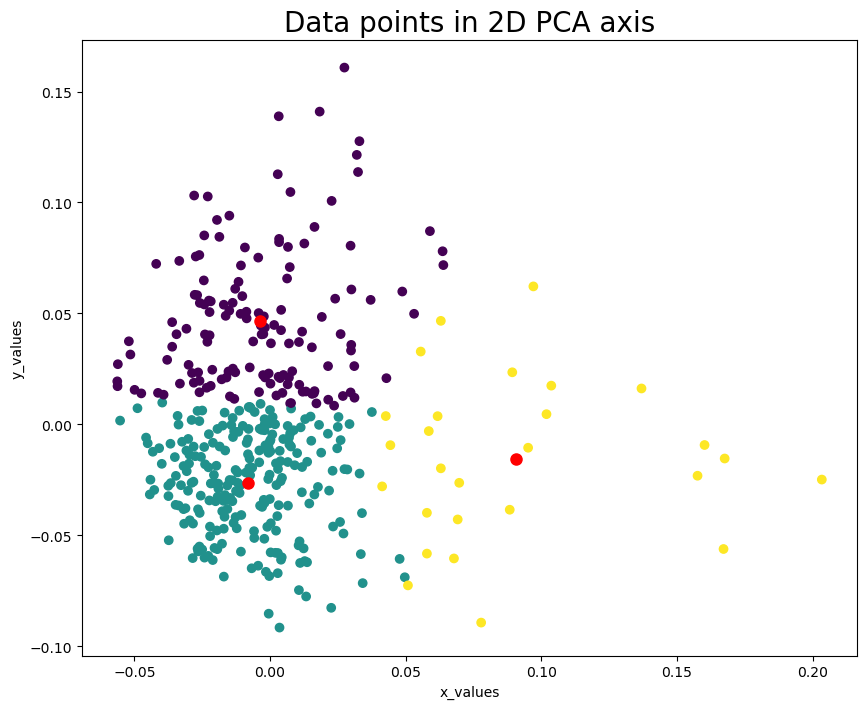

In [32]:
fig = plt.figure(figsize=(10,8))
plt.scatter(df_pca[1],df_pca[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

### Interpret each cluster by top 10 rated movies 

In [33]:
X['label'] = c_preds
X['mean'] = X.mean(axis=1)

In [34]:
for label, df in X.groupby('label'):
    print('Group {}:'.format(label+1))
    for movie in df.nlargest(10, 'mean').index.values:
        print(movie)
    print('-'*20)
    print()

Group 1:
Harry Potter and the Sorcerer's Stone (2001)
Monsters  Inc.(2001)
Harry Potter and the Deathly Hallows: Part 2 (2011)
Harry Potter and the Goblet of Fire (2005)
Beauty and the Beauty (1991)
Harry Potter and the Chamber of Secrets (2002)
Aladdin (1992)
Captain America: Civil War (2016)
Toy Story 2 (1999)
Rush Hour 2 (2001)
--------------------

Group 2:
Life is Beautiful (1997)
The Shawshank Redemption (1994)
Spirited Away (2001)
Good Will Hunting (1997)
The Lion King (1994)
The Prestige (2006)
Memento (2000)
Leon (1994)
Schindler's List (1993)
Room (2015)
--------------------

Group 3:
The Shining (1980)
Carrie (1976)
Halloween (1978)
Alien (1979)
Night of the Living Dead (1968)
Jaws (1975)
The Visit (2015)
The Ring (2002)
You're Next (2011)
The Blair Witch Project (1999)
--------------------



Finally by observing the top 10 movies with the highest average rating, we can have a sense of what each cluster is made of.
And they contains mainly:

1. **Adventure and action movies**
2. **Drama movies**
3. **Horror and thriller**

## Almost done!

Now if a user chooses a certain movie, we could just recommend movies in the same genre! To put our model ready to use, I encapsulate our analysis above to the following `MovieRecommender` class.

In [37]:
class MovieRecommender:
    """Recommend movies by KNN and KNN+K-means models.

    This recommender load a movie rating matrix and recommend movies to every user

    Parameters
    ----------
    rec_num : int, default=5
        Desired recommended movies.

    n_neighbors : int, default=10
        Number of users used to compute average rating in KNN.

    Attributes
    ----------
    df_raw : pd.DataFrame (m_users,n_movies)
        Loaded row movie rating frame.

    df_filled : pd.DataFrame (m_users,n_movies)
        Row movie rating dataframe with NaN filled by KNN model.

    df_favorite : pd.DataFrame (m_users,rec_num)
        Top `rec_num` movies rated by each user.

    df_recommend_overall : pd.DataFrame (m_users,rec_num)
       Top `rec_num` movies recommended to each user overall.

    df_recommend_genres : List[pd.DataFrame (m_users, rec_num), ...]
        Top `rec_num` movies recommended to each user in different genres.

    genres_label : List[int]
        Movie genre labels by K-means clustering.

    """

    def __init__(self, rec_num=5, n_neighbors=10):
        self.rec_num = rec_num
        self.n_neighbors = n_neighbors

        self.df_raw = None
        self.df_filled = None

        self.df_favorite = None
        self.df_recommend_overall = None
        self.df_recommend_genres = []

        self.genres_label = None

    def _get_movie_list(self, df, user_no):
        return df.iloc[user_no, :]

    def _mask_raw_pos(self, df):
        return df.mask(~self.df_raw.isna().values, -1)

    def _knn_fill(self):
        df_complete = KNNImputer(
            n_neighbors=self.n_neighbors).fit_transform(self.df_raw)
        df_complete = pd.DataFrame(df_complete, columns=self.df_raw.columns)
        return df_complete

    def _pca_kmeans(self, k):
        df_normalized = normalize(self.df_filled.T, norm='l2')
        df_pca = PCA(n_components=3).fit_transform(df_normalized)

        clusterer = KMeans(n_clusters=k, random_state=30).fit(df_pca)
        preds = clusterer.predict(df_pca)
        return preds

    def load_data(self, file_path):
        """Load movie rating matrix

        Parameters
        ----------
        file_path : str
            The file path of csv file storing movie rating matrix.

        Returns
        -------
        None

        """
        df_raw = pd.read_csv(file_path)
        df_raw.columns = df_raw.columns.str.replace(
            ":", "").str.replace("/", "")
        df_raw = df_raw.iloc[:, :400].dropna(how='all').reset_index(drop=True)
        self.df_raw = df_raw
        self.df_filled = self._knn_fill()

    def watched_movie_list(self, user_no):
        """Get list of movies that have been watched by this user

        Parameters
        ----------
        user_no : int
            Target user No.

        Returns
        -------
        Movie list this user have watched.

        """
        return self.df_raw.iloc[user_no, :].dropna().index

    def favorite_overall(self, user_no):
        """Find top `rec_num` movie that the user has watched.

        Parameters
        ----------
        user_no : int
            Target user No.

        Returns
        -------
        favorite_movies: List[] of length `rec_num`
            Top `rec_num` movies this user have watched.

        """
        if not self.df_favorite:
            df_favorite_movie = self.df_raw.fillna(-1)
            self.df_favorite = pd.DataFrame(df_favorite_movie.values.argsort(axis=1)[:, -self.rec_num:]).applymap(
                lambda idx: df_favorite_movie.columns[idx])
        favorite_movies = self._get_movie_list(self.df_favorite, user_no)
        return favorite_movies

    def recommend_overall(self, user_no):
        """Recommend top `rec_num` movie overall to this user.

        Parameters
        ----------
        user_no : int
            Target user No.

        Returns
        -------
        recommended_movies: List[] of length `rec_num`
            Top `rec_num` movies this we recommend to this user.

        """
        if not self.df_recommend_overall:
            df_filled_masked = self._mask_raw_pos(self.df_filled)
            self.df_recommend_overall = pd.DataFrame(
                df_filled_masked.values.argsort(axis=1)[:, -self.rec_num:]).applymap(
                lambda idx: df_filled_masked.columns[idx])
        recommended_movies = self._get_movie_list(
            self.df_recommend_overall, user_no)
        return recommended_movies

    def recommend_by_genres(self, user_no=None, movie_name=None, movie_no=None, k=3):
        """Recommend top `rec_num` movie related to current `movie_no` or `movie_name` to this user.

        Parameters
        ----------
        user_no : int
            Target user No.

        movie_name : str
            Target movie_name.

        movie_no : int
            Target movie No. Overridden if given movie num

        k : int, default = 3
            k used in K-means model

        Returns
        -------
        recommended_movies: List[] of length `rec_num`
            Top `rec_num` movies this we recommend to this user.

        """
        if movie_name:
            movie_no = self.df_raw.columns.to_list().index(movie_name)

        if self.genres_label is None:
            self.genres_label = self._pca_kmeans(k)
        if len(self.df_recommend_genres) == 0:
            for label in range(k):
                df_filled_masked = self._mask_raw_pos(self.df_filled)
                df_within_cluster = df_filled_masked.loc[:,
                                    label == self.genres_label]
                df_within_cluster = pd.DataFrame(df_within_cluster.values.argsort(axis=1)[:, -self.rec_num:]).applymap(
                    lambda idx: df_within_cluster.columns[idx])
                self.df_recommend_genres.append(df_within_cluster)
        label = self.genres_label[movie_no]
        recommend_movies = self._get_movie_list(
            self.df_recommend_genres[label], user_no)
        return recommend_movies, label

Finally, I deploy both the KNN model and the upgraded KNN+K-means model as a [online demo](https://nuolei-movie.streamlit.app/) so that you can explore and enjoy!

<center>
<div id="images">
    <a href="https://nuolei-movie.streamlit.app/">
    <img class="demo" border="0" alt="demo_screenshot" src="readme/demo_screenshot.png"  height="300" width="300"/></a>
    <a href="https://nuolei-movie.streamlit.app/" target="_blank">
    <img class="demo2" border="0" alt="demo_screenshot2" src="readme/demo_screenshot2.png"  height="300" width="300"/></a>
</div>
</center>